In [1]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import networkx as nx
import random
from tqdm import tqdm

In [8]:
df=pd.read_csv('/srv/abacus-1/uniswapv2_TY_23/UniswapV2_daily_snapshot_sync_18012051_with_price.csv')

In [3]:
# Confirm the type of data
if data['price'].dtype != float:
    data['price'] = data['price'].astype(float)

In [6]:
# Update the network creation function to ensure reserve data is in float type
def create_network_with_float_constraints(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        # Convert reserves to float
        reserve0 = float(row['reserve0'])
        reserve1 = float(row['reserve1'])
        # Add vertices (tokens)
        G.add_node(row['token0.id'])
        G.add_node(row['token1.id'])

        # Add an edge from token0 to token1 with price and additional attributes
        forward_edge_attributes = {
            'price': 1 / row['price'] if row['price'] != 0 else 0,
            'reserve': reserve1,  # reserve of token1 for token0 to token1 edge
            'block_number': row['block_number'],
            'transactionIndex': row['transactionIndex'],
            'log_index': row['log_index']
        } 
        G.add_edge(row['token0.id'], row['token1.id'], **forward_edge_attributes)

        # Add the reverse edge from token1 to token0 with the inverse price
        reverse_edge_attributes = {
            'price': row['price'],
            'reserve': reserve0,  # reserve of token0 for token1 to token0 edge
            'block_number': row['block_number'],
            'transactionIndex': row['transactionIndex'],
            'log_index': row['log_index']
        }
        G.add_edge(row['token1.id'], row['token0.id'], **reverse_edge_attributes)

    return G


In [9]:
block_number_list=[18012030,16282783,16503307]
transactionIndex=[120,29,51]
log_index=[335,184,84]
# block_number_list=[16516403,12580295,18010651]
# transactionIndex=[39,264,111]
# log_index=[95,134,219]
#写一个函数，用这些参数，返回路径
list1=[]
def get_path(block_number,transactionIndex,log_index):
    return df[(df['block_number']==block_number)&(df['transactionIndex']==transactionIndex)&(df['log_index']==log_index)][['token0.symbol','token1.symbol','price']].values[0]
for i in range(3):
    print(get_path(block_number_list[i],transactionIndex[i],log_index[i]))
    list1.append(list(get_path(block_number_list[i],transactionIndex[i],log_index[i])))

['DAI' 'WETH' 1646.7063621819773]
['DAI' 'ENVT' 2.721282212561712e+17]
['ENVT' 'WETH' 4.4808245074109306e+17]


DAI WETH
ENVT ENVT


{('WETH',
  'DAI'): Text(0.24999996274709668, 0.43301271829021687, '1646.7063621819773'),
 ('DAI', 'ENVT'): Text(-0.5, -9.934107536579972e-09, '3.6747383104328525e-18'),
 ('ENVT',
  'WETH'): Text(0.2500000372529033, -0.43301270835610933, '2.2317321250722468e-18')}

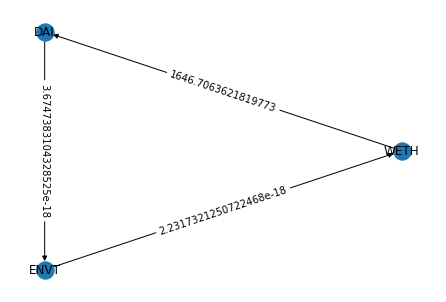

In [10]:
# list1=[['WETH' ,'DOGFUND' ,1000000000000001.0],['eMax' ,'DOGFUND' ,7.23030945724e-05],['eMax' ,'WETH' ,1395218483490.5652]]
import networkx as nx
G=nx.DiGraph()
start_token='WETH'
for i in list1:
    if i==list1[0]:
        if i[0]==start_token:
            G.add_edge(i[0],i[1],weight=1/i[2])
            last_token=i[1]
        else:
            G.add_edge(i[1],i[0],weight=i[2])
            last_token=i[0]
    else:
        #检查 i[0] 是否和上一个 i[1] 相等，如果相等,则 i[0]和 i[1] 顺序不变，否则，i[0]和 i[1] 顺序颠倒
        if i[0]==last_token:
            print(i[0],list1[list1.index(i)-1][1])
            G.add_edge(i[0],i[1],weight=1/i[2])
            last_token=i[1]
        else:
            G.add_edge(i[1],i[0],weight=i[2])
            last_token=i[0]
#可视化路径和边的权重
import matplotlib.pyplot as plt
#换一个布局
pos=nx.circular_layout(G)
nx.draw(G,pos,with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [11]:
prices=[]
for edge in G.edges():
    prices.append(G.edges[edge]['weight'])
#prices 里面的元素相乘
from functools import reduce
reduce(lambda x,y:x*y,prices)

1.350469081111165e-32

{('WETH',
  'ENVT'): Text(0.2500000372529033, -0.43301270835610933, '4.4808245074109306e+17'),
 ('DAI',
  'WETH'): Text(0.24999996274709668, 0.43301271829021687, '0.0006072728101171264'),
 ('ENVT', 'DAI'): Text(-0.5, -9.934107536579972e-09, '2.721282212561712e+17')}

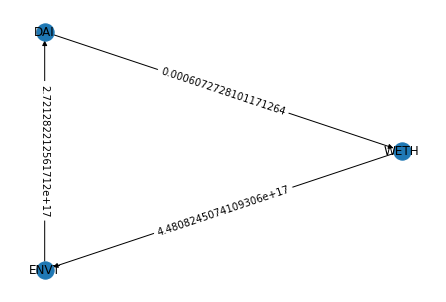

In [12]:
#将边的方向反转，边的权重取倒数
G1=G.reverse()
#可视化路径和边的权重
import matplotlib.pyplot as plt
#换一个布局
pos=nx.circular_layout(G1)
nx.draw(G1,pos,with_labels=True)
labels = nx.get_edge_attributes(G1,'weight')
labels={k:1/v for k,v in labels.items()}
nx.draw_networkx_edge_labels(G1,pos,edge_labels=labels)